In [1]:
from tqdm.notebook import tqdm

import numpy as np
import re
import requests
import string

### Some useful links on articles
$\bullet \href{https://learnpunjabi.org/pdf/IJCSI-8-5-3-327-331%20(1).pdf}{Automatic Keywords Extraction for Punjabi Language}$

$\bullet \href{https://learnpunjabi.org/pdf/Coling2012DEMOS025.pdf}{Complete Pre Processing phase of Punjabi Text Extractive
Summarization System}$

$\bullet \href{https://www.ijettjournal.org/volume-6/number-7/IJETT-V6N7P163.pdf}{Automatic Normalization of Punjabi Words}$


### General pipeline

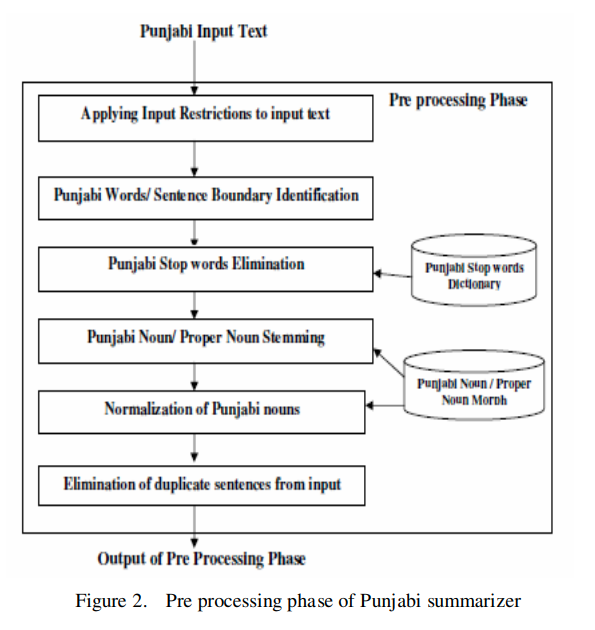

### Clean texts according to unicode
$\href{https://unicode-table.com/ru/blocks/gurmukhi/}{Gurmukhi}$

In [2]:
class TextCleaner():
    """
    Punjabi text cleaner
    """
    def __init__(self):        
        self.min_ascii = '0A00'
        self.max_ascii = '0A7F'
        self.min_digit_pa_ascii = '0A66'
        self.max_digit_pa_ascii = '0A6F'
        
        self.min_ord = int(self.min_ascii, 16)
        self.max_ord = int(self.max_ascii, 16)
        self.min_digit_pa_ord = int(self.min_digit_pa_ascii, 16)
        self.max_digit_pa_ord = int(self.max_digit_pa_ascii, 16)
        
        self.punctuation = string.punctuation + '।' + '॥' + '—' + '·' + '•' + '′' + '°' + '–'
        self.one_space_regex = r"\s((\s)(\s+)?)?"
        self.text = None

        self.dict_punct = dict(zip(list(self.punctuation), np.repeat(' ', len(self.punctuation))))
        
    def remove_punct(self, text):
        table = str.maketrans(self.dict_punct)
        text = text.translate(table)
        return text
    
    def remove_en(self, text):
        en_pattern = r'[A-z]'
        text = re.sub(en_pattern, ' ', text)
        return text
        
    def remove_num(self, text):
        num_pattern = r'[0-9]'
        text = re.sub(num_pattern, ' ', text)
        return text
    
    def remove_spaces(self, text):
        try:
            text = re.sub(self.one_space_regex, ' ', text)    
            text = text if text[0] != ' ' else text[1:]
            text = text if text[-1] != ' ' else text[:-1]
            return text
        
        except IndexError as e:
            return ''
    
    def is_pa_token(self, token):
        for ch in set(token):
            if ord(ch) < self.min_ord or ord(ch) > self.max_ord:
                return False
        return True

    def remove_foreign_lang(self, text):
        clean_text = ''
        for token in text.split():
            if self.is_pa_token(token):
                clean_text += ' ' + token
        return clean_text[1:]
    
    def is_pa_num(self, token):
        for ch in set(token):
            if ord(ch) >= self.min_digit_pa_ord and ord(ch) <= self.max_digit_pa_ord:
                return True
        return False
    
    def remove_pa_num(self, text):
        clean_text = ''
        for token in text.split():
            if not self.is_pa_num(token):
                clean_text += ' ' + token
        return clean_text[1:]
    
    def clean_text(self, text):
        text = self.remove_punct(text)
        text = self.remove_en(text)
        text = self.remove_num(text)
        text = self.remove_spaces(text)
        text = self.remove_foreign_lang(text)
        text = self.remove_pa_num(text)
        text = self.remove_spaces(text)
        return text

### Wiki

In [3]:
# with open('./data/dirty_corp_wiki_pa.txt', 'r') as f:
#     dirty_corp = f.read()
# dirty_corp = dirty_corp.split('^^^^^^')
# dirty_corp = dirty_corp[:-1]
# print(f'Num of texts: {len(dirty_corp)}')

In [4]:
# Cleaner = TextCleaner()
# clean_corp = []
# 
# for raw_line in tqdm(dirty_corp):
#     link, title = raw_line.split('<>')[:2]
#     text = ' '.join(raw_line.split('<>')[2:])
#     clean_text = Cleaner.clean_text(text)
#     clean_title = Cleaner.clean_text(title)
# 
#     clean_corp.append([clean_title, clean_text])

### Literature

In [5]:
with open('./data/pa_literature.txt', 'r') as f:
    dirty_corp = f.read()
dirty_corp = dirty_corp.split('^^^^^')
dirty_corp = dirty_corp[:-1]
print(f'Num of texts: {len(dirty_corp)}')

Num of texts: 28884


In [6]:
Cleaner = TextCleaner()
clean_corp = []

for raw_line in tqdm(dirty_corp):
    title, text = raw_line.split('<<<>>>')
    clean_text = Cleaner.clean_text(text)
    clean_title = Cleaner.clean_text(title)

    clean_corp.append([clean_title, clean_text])

  0%|          | 0/28884 [00:00<?, ?it/s]

### Unique

In [7]:
s = ' '.join([text for _, text in clean_corp])

print('Total: ', len(s.split()))
print('Unique: ', len(set(s.split())))

Total:  3782278
Unique:  147879


In [8]:
cut_l = [i[1] for i in clean_corp if len(i[1].split())>100]
len(cut_l)

12566

In [9]:
s = ' '.join([text for text in cut_l])

print('Total: ', len(s.split()))
print('Unique: ', len(set(s.split())))

Total:  2877072
Unique:  120791


### Stopwords were taken from this github:
$\href{https://github.com/fergiemcdowall/stopword/blob/1358610265a86bad9ba9444e22f3edda6fd93d44/src/stopwords_panGu.js}{Git}$

In [10]:
class StopWordsRemover():
    """
    Remove stopwords
    """
    def __init__(self, stop_words):
        self.stop_words = stop_words
        
    def remove_stop_words(self, text):
        clean_text = ''
        for token in text.split(' '):
            if token not in self.stop_words:
                clean_text += ' ' + token
        try: return clean_text[1:]
        except IndexError: return ''

### Wiki or literature

In [11]:
with open('./data/stopwords_pa.txt', 'r') as f:
    stopwords = f.read().split()

stop_remover = StopWordsRemover(stop_words=stopwords)

for pair in tqdm(clean_corp):
    pair[1] = stop_remover.remove_stop_words(pair[1])

  0%|          | 0/28884 [00:00<?, ?it/s]

### Unique

In [12]:
s = ' '.join([text for _, text in clean_corp])

print('Total: ', len(s.split()))
print('Unique: ', len(set(s.split())))

Total:  2443073
Unique:  147432


### Initial code of following stemmer
$\href{https://github.com/SimranKaur-23/Stemmer-in-punjabi/tree/main}{Git}$

In [13]:
class PunjabiStemmer():
    """
    Punjabi Stemmer Class
    """
    
    def __init__(self):
        self.suffixes = {1: ["ੀ ਆਂ", "िਆਂ", "ੂਆਂ", "ੀ ਏ", "ੀ ਓ"],
                         2: ["ਈ", "ੇ", "ू", "ु", "ी","ਏ"
                             "ि", "ा", "ੋ", "ਜ", "ਜ਼", "ਸ"],
                         3: ["िਓ", "ਾ ਂ", "ੀ ਂ", "ੋ ਂ","ਏ"],
                         4: ["ਿਉ ਂ", "ਵਾਂ" ],
                         5: ["ੀ ਆ", "िਆ", "ਈਆ"]}

    def rreplace(self, string, old, new, count=None):
        # for replacing old string with new string
        string_reverse = string[::-1]
        old_reverse = old[::-1]
        new_reverse = new[::-1]
        if count:
            final_reverse = string_reverse.replace(old_reverse, new_reverse, count)
        else:
            final_reverse = string_reverse.replace(old_reverse, new_reverse)
        result = final_reverse[::-1]
        return result
    
    def gen_replacement(self, suf, L):
        if L == 1 or L == 5:
            return suf[1:]
        return suf

    def stem(self, text):
        # Main function for punjabi stemming
        tag = [1, 2, 3, 4, 5]
        tag.reverse()
        new_text = ''
        
        for c, word in enumerate(text.split()):
            flag = 0
            for L in tag:
                if flag == 1:
                    break
                if len(word) > L + 1:  # Checking: minimum 3 letter words
                    for suf in self.suffixes[L]:
                        if word.endswith(suf):
                            new_word = self.rreplace(word,self.gen_replacement(suf,L), '', 1)
                            flag = 1
                            break
            if flag == 0:
                # If word length less than 3 (stop words)
                new_word = word
            
            new_text = ' '.join((new_text, new_word)) if c else new_word
        
        return new_text

### Wiki and literature

In [14]:
stemmer = PunjabiStemmer()

for pair in tqdm(clean_corp):
    pair[1] = stemmer.stem(pair[1])

  0%|          | 0/28884 [00:00<?, ?it/s]

In [15]:
s = ' '.join([text for _, text in clean_corp])

print('Total: ', len(s.split()))
print('Unique: ', len(set(s.split())))

Total:  2443073
Unique:  135556


In [16]:
class Lemmatization():
    def __init__(self):
        self.replace_dict = {'ੱ': '',
                             'ਂ': '',
                             '◌੍': 'ਰ',
                             '਼': ''}
    
    def lemmatize_token(self, token):
        for symb in self.replace_dict:
            token = token.replace(symb, self.replace_dict[symb])
        return token
    
    def lemmatize_text(self, text):
        lemmatized_text = ''
        for token in text.split():
            lemmatized_text += ' ' + self.lemmatize_token(token)
        return lemmatized_text[1:]

### Wiki and literature

In [17]:
lemmatizer = Lemmatization()

for pair in tqdm(clean_corp):
    pair[1] = lemmatizer.lemmatize_text(pair[1])

  0%|          | 0/28884 [00:00<?, ?it/s]

In [18]:
s = ' '.join([text for _, text in clean_corp])

print('Total: ', len(s.split()))
print('Unique: ', len(set(s.split())))

Total:  2443065
Unique:  116655


### Just some examples of our cleaning

In [24]:
text_n = np.random.randint(low=0, high=len(clean_corp))

initial_text = dirty_corp[text_n].split('<<<>>>')[-1]
final_text = clean_corp[text_n][1]

print(f'Before: {initial_text}')
print(f'After: {final_text}')

Before: ਜਿੱਥੇ ਸੀਤ ਹਵਾਵਾਂ ਮੇਲਦੀਆਂ
ਪਿੰਡਿਆਂ ਦੇ ਨਾਲ ਨੇ ਖੇਲਦੀਆਂ
ਜਿੱਥੇ ਕੂਕਾਂ ਵੱਜਣ ਰੇਲਦੀਆਂ

ਮੈਂ ਓਥੋਂ ਵਾਜਾਂ ਮਾਰਦਾਂ 
ਉਸ ਦੇਸ਼ ਤੋਂ ਵਾਜਾਂ ਮਾਰਦਾਂ

ਜਿੱਥੇ ਸਾਂਝ ਪ੍ਰੀਤਾਂ ਜੁੜੀਆਂ ਨੇ
ਸਿਰ ਕੱਫਣ ਬੰਨ ਲਏ ਬੁੜ੍ਹੀਆਂ ਨੇ
ਹੱਥ ਝੰਡੇ ਫੜ੍ਹ ਲੈ ਕੁੜੀਆਂ ਨੇ

ਮੈਂ ਓਥੋਂ ਵਾਜਾਂ ਮਾਰਦਾਂ 
ਉਸ ਦੇਸ਼ ਤੋਂ ਵਾਜਾਂ ਮਾਰਦਾਂ

ਜਿੱਥੇ ਬੜ੍ਹਕ ਜਵਾਨੀ ਮਾਰਦੀ
ਨਾ ਰੋਕਾਂ ਅੱਗੇ ਹਾਰਦੀ
ਜਿੰਦ ਅੱਗੇ ਹੋ-ਹੋ ਵਾਰਦੀ

ਮੈਂ ਓਥੋਂ ਵਾਜਾਂ ਮਾਰਦਾਂ
ਉਸ ਦੇਸ਼ ਤੋਂ ਵਾਜਾਂ ਮਾਰਦਾਂ

ਜਿੱਥੇ ਬਾਬਿਆਂ ਲਾਏ ਡੇਰੇ ਨੇ
ਸੂਰਜ ਨਾਲ ਜਿੱਦਣ ਨ੍ਹੇਰੇ ਨੇ
ਜਿੱਥੇ ਹੋਵਣ ਵਾਲੇ ਸਵੇਰੇ ਨੇ

ਮੈਂ ਓਥੋਂ ਵਾਜਾਂ ਮਾਰਦਾਂ
ਉਸ ਦੇਸ਼ ਤੋਂ ਵਾਜਾਂ ਮਾਰਦਾਂ

ਜਿੱਥੇ ਹਾਕਮ ਕੂਕਰ ਬਣਿਆ ਹੈ
ਸਾਡਾ ਵੀ 'ਮੁੱਕਾ' ਤਣਿਆ ਹੈ
ਇਹ ਮੁੱਦਤ ਪਿੱਛੋਂ ਜਣਿਆ ਹੈ

ਮੈਂ ਓਥੋਂ ਵਾਜਾਂ ਮਾਰਦਾਂ
ਉਸ ਦੇਸ਼ ਤੋਂ ਵਾਜਾਂ ਮਾਰਦਾਂ

After: ਸੀਤ ਹਵਾ ਮੇਲਦੀਆ ਪਿੰਡਿਆ ਖੇਲਦੀਆ ਕੂਕਾ ਵਜਣ ਰੇਲਦੀਆ ਮੈ ਓਥੋ ਵਾਜਾ ਮਾਰਦਾ ਦੇਸ਼ ਵਾਜਾ ਮਾਰਦਾ ਸਾਝ ਪ੍ਰੀਤਾ ਜੁੜੀਆ ਸਿਰ ਕਫਣ ਬੰਨ ਲਏ ਬੁੜ੍ਹੀਆ ਹਥ ਝੰਡ ਫੜ੍ਹ ਕੁੜੀਆ ਮੈ ਓਥੋ ਵਾਜਾ ਮਾਰਦਾ ਦੇਸ਼ ਵਾਜਾ ਮਾਰਦਾ ਬੜ੍ਹਕ ਜਵਾਨੀ ਮਾਰਦੀ ਰੋਕਾ ਹਾਰਦੀ ਜਿੰਦ ਵਾਰਦੀ ਮੈ ਓਥੋ ਵਾਜਾ ਮਾਰਦਾ ਦੇਸ਼ ਵਾਜਾ ਮਾਰਦਾ ਬਾਬਿਆ ਲਾਏ ਡੇਰ ਸੂਰ ਜਿਦਣ ਨ੍ਹੇਰ ਹੋਵਣ ਸਵੇਰ ਮੈ ਓਥੋ ਵਾਜਾ ਮਾਰਦਾ ਦੇਸ਼ ਵਾਜਾ ਮਾਰਦਾ ਹਾਕਮ ਕੂਕਰ ਸਾਡਾ ਮੁਕਾ ਤਣਿਆ ਮੁਦਤ ਪਿਛੋ ਜਣਿਆ ਮੈ ਓਥੋ ਵਾਜਾ ਮਾਰਦ

In [ ]:
# with open('./clean_corp_wiki_pa.txt', 'w') as f:
#     for title, text in tqdm(clean_corp):
#         f.write(','.join((title, text)))
#         f.write('\n')

In [26]:
with open('./data/clean_corp_literature_pa_cut.txt', 'w') as f:
    for title, text in tqdm(clean_corp):
        f.write(','.join((title, text)))
        f.write('\n')

  0%|          | 0/28884 [00:00<?, ?it/s]